In [18]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Chemin du répertoire d'images
# source_dir = "Images"
# output_dir = "Dataset"

# # Ratios pour train, val et test
# train_ratio = 0.7
# val_ratio = 0.2
# test_ratio = 0.1

# # Vérification que les ratios forment un total de 1.0
# assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Les ratios doivent totaliser 1.0"

# # Création des répertoires de sortie
# for split in ['train', 'val', 'test']:
#     split_dir = os.path.join(output_dir, split)
#     os.makedirs(split_dir, exist_ok=True)

# # Parcourir chaque sous-dossier (classe/race)
# for breed in os.listdir(source_dir):
#     breed_path = os.path.join(source_dir, breed)
#     if not os.path.isdir(breed_path):
#         continue

#     # Liste des fichiers pour la classe
#     images = [os.path.join(breed_path, img) for img in os.listdir(breed_path)]
    
#     # Diviser les images en train, val et test
#     train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
#     val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

#     # Fonction pour copier les fichiers dans les répertoires appropriés
#     def copy_images(images, split):
#         split_dir = os.path.join(output_dir, split, breed)
#         os.makedirs(split_dir, exist_ok=True)
#         for img in images:
#             shutil.copy(img, split_dir)
    
#     # Copier les fichiers dans les dossiers train, val et test
#     copy_images(train_imgs, 'train')
#     copy_images(val_imgs, 'val')
#     copy_images(test_imgs, 'test')

# print("Les images ont été divisées en train, val et test.")

In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import time

# Configuration des chemins des données
train_dir = "/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train"
val_dir = "/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val"
test_dir = "/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/test"

# Prétraitement des données
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajout d'une tête personnalisée
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model_vgg16= Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Compilation du modèle
model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
EPOCHS = 10
start_time_fit = time.time() # en secondes
history = model_vgg16.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator)
time_fit = (time.time() - start_time_fit)

# Évaluation sur les données de test
test_loss, test_acc = model_vgg16.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Found 505 images belonging to 3 classes.
Found 144 images belonging to 3 classes.
Found 74 images belonging to 3 classes.
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4088 - loss: 3.9550 - val_accuracy: 0.8403 - val_loss: 0.4267
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6351 - loss: 1.1361 - val_accuracy: 0.7917 - val_loss: 0.4587
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7314 - loss: 0.6028 - val_accuracy: 0.9097 - val_loss: 0.3041
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7699 - loss: 0.5476 - val_accuracy: 0.9028 - val_loss: 0.2894
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7855 - loss: 0.5208 - val_accuracy: 0.9167 - val_loss: 0.2539
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8220 - loss: 0.4358 - val_accuracy: 0.8958 - val_loss: 0.2898
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8078 - loss: 0.4491 - val_accuracy: 0.9167 - val_loss: 0.2

In [20]:
# (Facultatif) Débloquer les couches pour un fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time_fit = time.time() # en secondes
history_finetune = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)
time_fit = (time.time() - start_time_fit)

# Évaluation finale
start_time_test = time.time() # en secondes
test_loss, test_acc = model_vgg16.evaluate(test_generator)
time_test = (time.time() - start_time_test)

print(f"Fine-tuned Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7398 - loss: 0.7984 - val_accuracy: 0.9236 - val_loss: 0.2336
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8637 - loss: 0.3363 - val_accuracy: 0.9653 - val_loss: 0.1516
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9074 - loss: 0.2337 - val_accuracy: 0.9583 - val_loss: 0.1361
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9099 - loss: 0.1955 - val_accuracy: 0.9583 - val_loss: 0.1711
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9689 - loss: 0.1326 - val_accuracy: 0.9306 - val_loss: 0.2170
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9671 - loss: 0.1161 - val_accuracy: 0.9653 - val_loss: 0.1564
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9567 - loss: 0.1091 - val_accuracy: 0.9583 - val_loss: 0.1477
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9757 - loss: 0.0980 - val_accuracy: 0.9583 - val_loss:

In [33]:

# Évaluation finale
start_time_test = time.time() # en secondes
test_loss, test_acc = model_vgg16.evaluate(test_generator)
time_test = (time.time() - start_time_test)

print(f"Fine-tuned Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9087 - loss: 0.7767
Fine-tuned Test Accuracy: 91.89%


In [34]:
print("Temps d'entraînement:", time_fit)
print("Temps de test:", time_test)

Temps d'entraînement: 456.1967120170593
Temps de test: 4.591107130050659


In [21]:
model_vgg16.save('dog_breed_vgg16_p7.h5')

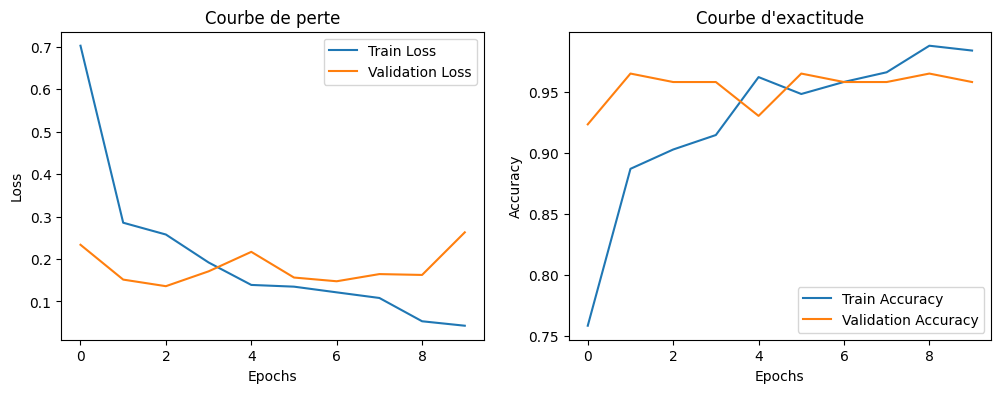

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# Exemple de courbes de perte et d'exactitude
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 4))
    
    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Courbe de perte')
    
    # Courbe d'exactitude
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Courbe d\'exactitude')
    
    plt.show()

# Exemple de matrice de confusion
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de confusion')
    plt.show()

# Exemple de courbes ROC et AUC
def plot_roc_auc(y_true, y_scores, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbes ROC multi-classes')
    plt.legend(loc='best')
    plt.show()

# Utilisation des fonctions
# history = model.fit(...)  # Historique de l'entraînement
plot_loss_accuracy(history_finetune)

# y_true = ...  # Vraies étiquettes
# y_pred = ...  # Prédictions du modèle
# class_names = [...]  # Noms des classes
#plot_confusion_matrix(y_true, predictions, class_names)

# y_scores = ...  # Scores de prédiction du modèle
# n_classes = len(class_names)
# plot_roc_auc(y_true, y_scores, n_classes)

## YOLO

In [23]:
from ultralytics import YOLO

# Charger un modèle pré-entraîné YOLOv11 pour la classification
model_yolo = YOLO('yolo11n-cls.pt')

# Commencer l'entraînement avec votre dataset
model_yolo.train(data='/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset', epochs=10, imgsz=224)

New https://pypi.org/project/ultralytics/8.3.51 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.44 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train111, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train... 505 images, 0 corrupt: 100%|██████████| 505/505 [00:00<?, ?it/s]
val: Scanning /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... 144 images, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to /Users/randaalsabbagh/runs/classify/train111
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G    0.05641          9        224: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all      0.951          1



10 epochs completed in 0.049 hours.
Optimizer stripped from /Users/randaalsabbagh/runs/classify/train111/weights/last.pt, 3.2MB
Optimizer stripped from /Users/randaalsabbagh/runs/classify/train111/weights/best.pt, 3.2MB

Validating /Users/randaalsabbagh/runs/classify/train111/weights/best.pt...
Ultralytics 8.3.44 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train... found 505 images in 3 classes ✅ 
val: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... found 144 images in 3 classes ✅ 
test: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/test... found 74 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


                   all      0.993          1
Speed: 0.0ms preprocess, 13.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/randaalsabbagh/runs/classify/train111


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x33b5502e0>
curves: []
curves_results: []
fitness: 0.9965277910232544
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9930555820465088, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9965277910232544}
save_dir: PosixPath('/Users/randaalsabbagh/runs/classify/train111')
speed: {'preprocess': 0.0003725290298461914, 'inference': 13.329605261484781, 'loss': 5.794896019829644e-05, 'postprocess': 3.9736429850260414e-05}
task: 'classify'
top1: 0.9930555820465088
top5: 1.0

Inference

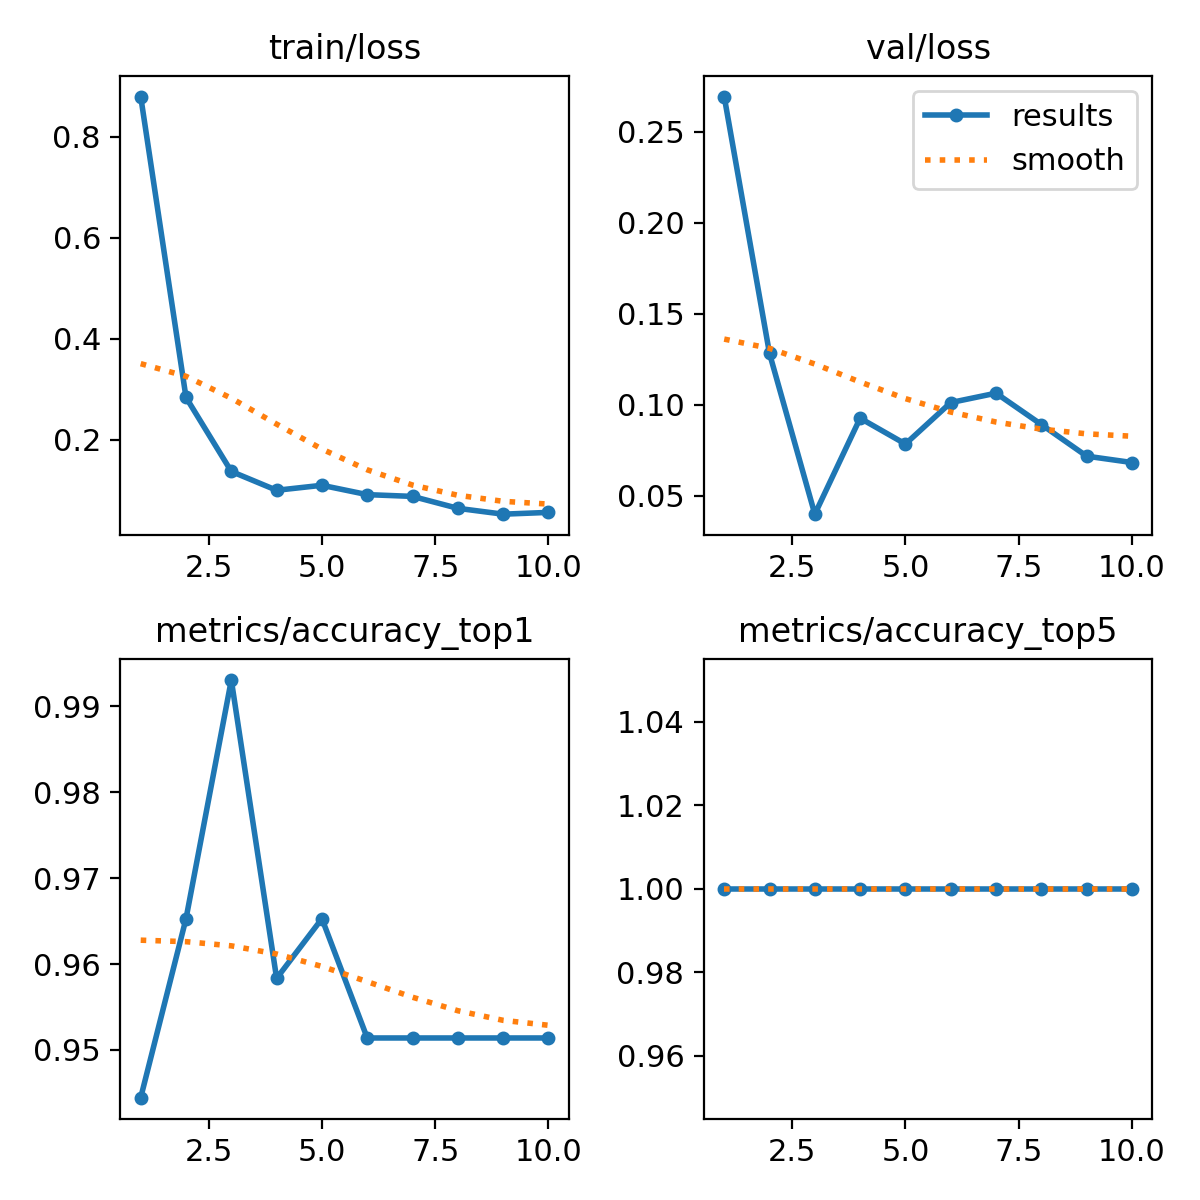

In [24]:
from IPython.display import Image
Image("/Users/randaalsabbagh/runs/classify/train106/results.png", width=600)

In [25]:
metrics = model_yolo.val()  # no arguments needed
# You can take a look at certain stats like the following
metrics.top1  
metrics.top5  

Ultralytics 8.3.44 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train... found 505 images in 3 classes ✅ 
val: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... found 144 images in 3 classes ✅ 
test: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/test... found 74 images in 3 classes ✅ 


val: Scanning /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... 144 images, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


                   all      0.993          1
Speed: 0.0ms preprocess, 15.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/randaalsabbagh/runs/classify/train1112


1.0

In [26]:
metrics.speed

{'preprocess': 0.0005629327562120226,
 'inference': 15.245924393335978,
 'loss': 8.112854427761502e-05,
 'postprocess': 6.622738308376736e-05}

In [27]:
# Exemple d'utilisation de `model.predict()` pour obtenir les prédictions
predictions = model_yolo.predict('/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train/Afghanhound/n02088094_13909.jpg')  # Remplacez avec le chemin de votre image

# Les prédictions contiennent des objets comme des boîtes de détection et des probabilités
for prediction in predictions:
    boxes = prediction.boxes  # Les boîtes de détection
    probs = prediction.probs  # Les probabilités des prédictions (si disponible)
    print(probs)


image 1/1 /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train/Afghanhound/n02088094_13909.jpg: 224x224 Afghanhound 1.00, Scottishdeerhound 0.00, Maltese 0.00, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
ultralytics.engine.results.Probs object with attributes:

data: tensor([9.9982e-01, 4.1487e-05, 1.3802e-04])
orig_shape: None
shape: torch.Size([3])
top1: 0
top1conf: tensor(0.9998)
top5: [0, 2, 1]
top5conf: tensor([9.9982e-01, 1.3802e-04, 4.1487e-05])


In [28]:
# Classe la plus probable et sa probabilité
top1_class = probs.top1
top1_confidence = probs.top1conf
print(f"Classe la plus probable: {top1_class}, Probabilité: {top1_confidence}")

# Classes et leurs probabilités
top5_classes = probs.top5
top5_confidences = probs.top5conf
print(f"Classes: {top5_classes}")
print(f"Probabilités des classes: {top5_confidences}")

Classe la plus probable: 0, Probabilité: 0.9998205304145813
Classes: [0, 2, 1]
Probabilités des classes: tensor([9.9982e-01, 1.3802e-04, 4.1487e-05])


In [29]:
# Après l'entraînement, vous pouvez sauvegarder le modèle
model_yolo.save("/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/model_yolo.pt")  # Remplacez ce chemin par le répertoire où vous voulez sauvegarder le modèle

In [30]:
# Export the model to ONNX format
path = model_yolo.export(format="onnx")  # return path to exported model

Ultralytics 8.3.44 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)

PyTorch: starting from '/Users/randaalsabbagh/runs/classify/train111/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 3) (3.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.43...
ONNX: export success ✅ 0.6s, saved as '/Users/randaalsabbagh/runs/classify/train111/weights/best.onnx' (5.9 MB)

Export complete (0.6s)
Results saved to /Users/randaalsabbagh/runs/classify/train111/weights
Predict:         yolo predict task=classify model=/Users/randaalsabbagh/runs/classify/train111/weights/best.onnx imgsz=224  
Validate:        yolo val task=classify model=/Users/randaalsabbagh/runs/classify/train111/weights/best.onnx imgsz=224 data=/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset  
Visualize:       https://netron.app
